In [49]:
# 코드 목적 : 레어 메뉴는 더 품절률이 높냐 
# 코드 작성일 : 24.8.6

In [50]:
import os

if 'original_dir' not in globals() :
    original_dir = os.getcwd()
    original_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(original_dir)))))
    os.chdir(original_dir)
exec(open('setup/default.py').read())
import scipy.stats as stats


In [59]:
menu_w_sold_out = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/menu_w_soldout_w_first_menu.csv')
menu_w_sold_out['menu_no'] = menu_w_sold_out.groupby(['day', 'meal_time'])['day'].transform('size')
menu_w_sold_out = menu_w_sold_out[['post_no','day','meal_time','course_no','first_menu','menu_no','is_soldout']]
target_w_sold_out = menu_w_sold_out[(menu_w_sold_out.menu_no>1)&
                     (menu_w_sold_out.day>='2023-06-01')].reset_index(drop=True)
target_w_sold_out.loc[:, 'rep'] = 0

In [60]:
first_menu_similarity = pd.read_csv(os.getcwd()+'/data/preproc/main/feature_lab_v1/first_menu_similarity.csv')

threshold = 0.7
first_menu_similarity = first_menu_similarity.loc[first_menu_similarity.sim_score>=threshold,['target_menu','menu','sim_score']]

In [67]:
target_w_sold_out['sim_menu'] = 0
target_w_sold_out['only_menu_2'] = 0
target_w_sold_out['only_menu_2_soldout'] = 0
target_w_sold_out['soldout_ratio'] = float('nan')

In [68]:
for i in tqdm(range(target_w_sold_out.shape[0])):
    target_menu, target_date, target_mt = target_w_sold_out.loc[i, ['first_menu', 'day', 'meal_time']]
    # 유사 메뉴 
    sim_menu = first_menu_similarity[first_menu_similarity.target_menu == target_menu].menu.tolist()
    # 구간 시작일 
    start_date = (datetime.strptime(target_date, "%Y-%m-%d") - relativedelta(months=6) + relativedelta(days=1)).strftime('%Y-%m-%d')
    if target_mt == 'lunch' : # lunch인 경우 (6달 전 ~ 어제)
        target_df = menu_w_sold_out[(menu_w_sold_out.day>=start_date) & 
                            (menu_w_sold_out.day<target_date) &
                            (menu_w_sold_out.first_menu.isin(sim_menu))
                            ]
    else : # dinner 인 경우 (6달 전 ~ 오늘 점심)
        target_df = menu_w_sold_out[(menu_w_sold_out.day>=start_date) & 
                            (menu_w_sold_out.day<=target_date)&
                            ((menu_w_sold_out.day!=target_date)|(menu_w_sold_out.meal_time!='dinner')) &
                            (menu_w_sold_out.first_menu.isin(sim_menu))
                            ]    
    
    sim_menu = len(target_df) # 몇번 나왔는지?
    # 품절률 계산용 
    only_menu_2 = (target_df['menu_no'] >= 2).sum() # 메뉴 2개 이상 나온 경우
    only_menu_2_soldout = ((target_df['menu_no'] >= 2) & target_df['is_soldout']).sum() # 메뉴 2개 이상 나왔는데 품절
    if only_menu_2>0 :
        soldout_ratio = only_menu_2_soldout/only_menu_2
    else :
        soldout_ratio = float('nan')

    target_w_sold_out.loc[i, ['sim_menu', 'only_menu_2', 'only_menu_2_soldout', 'soldout_ratio']] = sim_menu, only_menu_2, only_menu_2_soldout, soldout_ratio




100%|██████████| 814/814 [00:00<00:00, 825.97it/s]


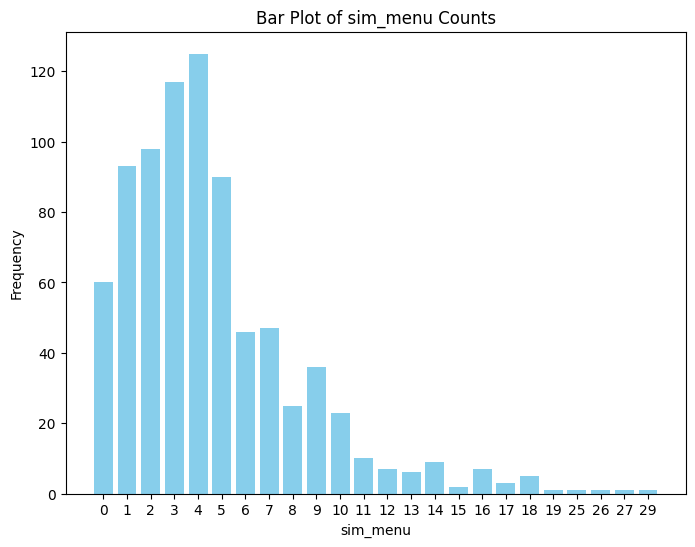

In [94]:
# 6개월 내 비슷한 메뉴 수 분포 
import matplotlib.pyplot as plt
# groupby와 size를 사용하여 집계
grouped_data = target_w_sold_out.groupby(['sim_menu'],dropna = False).size().to_frame('size').reset_index()

# 히스토그램 그리기
plt.figure(figsize=(8, 6))
plt.bar(grouped_data['sim_menu'].astype(str), grouped_data['size'], color='skyblue')
plt.xlabel('sim_menu')
plt.ylabel('Frequency')
plt.title('Bar Plot of sim_menu Counts')
plt.show()


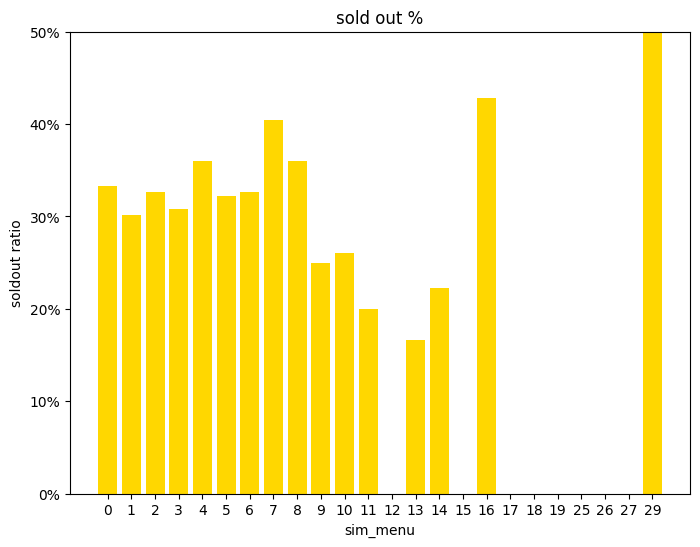

In [97]:

# 품절률
grouped_data = target_w_sold_out.groupby(['sim_menu'],dropna=False).agg(
    tot = ('is_soldout','size'), 
    soldout = ('is_soldout',lambda x: x.sum())
).reset_index()
grouped_data['ratio'] = grouped_data['soldout']/ grouped_data['tot']

# 히스토그램 그리기
plt.figure(figsize=(8, 6))
plt.bar(grouped_data['sim_menu'].astype(str), grouped_data['ratio'], color='gold')
plt.xlabel('sim_menu')
plt.ylabel('soldout ratio')
plt.title('sold out %')
plt.ylim(0, 0.5) 
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x*100)}%'))
plt.show()
